# The goal of this program is to create a live tracker of a hockey game.
## &emsp; Stats I would like to have live figures on are:
## &emsp;&emsp; Goals: 
### &emsp;&emsp;&emsp; [1] Graph of goals per team vs time-elapsed, w/ goal differential
### &emsp;&emsp;&emsp; [2] Table of goals per team per period, PPG's, SHG's

## &emsp; &emsp; Shots:
### &emsp;&emsp;&emsp; [1] Graph of shots per team vs time-elapsed, w/ shot differential
### &emsp;&emsp;&emsp; [2] Top 5 shooters for each team by: shots, missed shots, shot attempts, shooting%, +/-

##  &emsp;&emsp; Special Teams
### &emsp;&emsp;&emsp; [1] PIM per team, PP's per team, PPG's per team, PK's per team
### &emsp;&emsp;&emsp; [2] Table of penalties: Team, period, player, penalty, time

## Import necessary modules

In [1]:
from nhlstats import *
from nhlstats.formatters import csv
import pandas as pd, numpy as np
from datetime import *
from nhl import *
import ipywidgets as widgets
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import style, dates
import matplotlib.gridspec as gridspec
import datetime
from datetime import time
import time
from matplotlib.ticker import MaxNLocator
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
%matplotlib inline 

Hello world


In [2]:
today = date.today()
yesterday = today + timedelta(days=-1)

## Determine which game we want to look at

In [4]:
# Download data to pandas DF
games = pd.DataFrame(list_games(yesterday))
games = games.drop(columns=['season'])

#Create lists for all teams playing, and all game_id's
teams = []
game_ids = []
[teams.append(i) for i in games.away_team]
[teams.append(i) for i in games.home_team]
[game_ids.append(i) for i in games.game_id]

teams.sort()
def lst_unique(x):
    return list(dict.fromkeys(x))
teams = lst_unique(teams)

team_select = widgets.Dropdown(
    options=teams,
    value=teams[0],
    description='Team Name: ',
    disabled=False
)
display(games)

print("Which Team Are You Watching Today?")
display(team_select)

,away_score,away_team,date,game_id,game_state,home_score,home_team
0,2,San Jose Sharks,2020-03-12,2019021079,Final,6,Chicago Blackhawks
1,4,Winnipeg Jets,2020-03-12,2019021080,Final,2,Edmonton Oilers
2,4,St. Louis Blues,2020-03-12,2019020876,Final,2,Anaheim Ducks
3,2,New York Rangers,2020-03-12,2019021081,Final,3,Colorado Avalanche
4,2,Ottawa Senators,2020-03-12,2019021082,Final,3,Los Angeles Kings
5,0,Nashville Predators,2020-03-12,2019021083,Scheduled,0,Toronto Maple Leafs
6,0,Buffalo Sabres,2020-03-12,2019021084,Scheduled,0,Montréal Canadiens
7,0,Philadelphia Flyers,2020-03-12,2019021085,Scheduled,0,Tampa Bay Lightning
8,0,Carolina Hurricanes,2020-03-12,2019021086,Scheduled,0,New Jersey Devils
9,0,Detroit Red Wings,2020-03-12,2019021087,Scheduled,0,Washington Capitals


Which Team Are You Watching Today?


Dropdown(description='Team Name: ', options=('Anaheim Ducks', 'Arizona Coyotes', 'Buffalo Sabres', 'Calgary Fl…

## Identify `game_id` based on drop down list value. Download `plays`, `shifts`, `shots` data into DF's

In [5]:
team = team_select.value
game_id = games[(games.away_team == team) | (games.home_team == team)]['game_id'].min()

tL = pd.read_csv('teamList.csv')
Home = games[games.game_id == game_id].home_team.min()
Home = tL[tL.team_name == Home].team_abbrv.max()
Home_Color = tL[tL.team_abbrv == Home].home_c.max()

Away = games[games.game_id == game_id].away_team.min()
Away = tL[tL.team_name == Away].team_abbrv.max()
Away_Color = tL[tL.team_abbrv == Away].away_c.max()

print(f"Home: {Home} {Home_Color} \nAway: {Away} {Away_Color}")

#Columns to keep in plays and shots DF's
keys = ['datetime','event_description','event_secondary_type','event_type','period','period_time','team_for']

plays = pd.DataFrame(list_plays(game_id))
plays = plays[keys]

shifts = pd.DataFrame(list_shifts(game_id))   #Not sure if this DF is necessary for any part of this program

shots = pd.DataFrame(list_shots(game_id))     #`shots` is just a refined DF of `plays` and may also not be needed
shots = shots[keys]

Home: COL #6F263D 
Away: NYR #0038A8


### Add column to `shots, plays` DF's for total game time elapsed

In [6]:
# Add column to shots Df for total time played
shots['Time'] = pd.to_datetime(shots.period_time, format="%M:%S")
plays['Time'] = pd.to_datetime(plays.period_time, format="%M:%S")
plays['Minute'] = plays['Time'].dt.minute
plays['Second'] = plays['Time'].dt.second

plays_1 = plays[plays.period == 1].reset_index()

plays_2 = plays[plays.period == 2].reset_index()
plays_2.Time += timedelta(minutes=20)
plays_2.Minute += 20

plays_3 = plays[plays.period == 3].reset_index()
plays_3.Time += timedelta(minutes=40)
plays_3.Minute += 40

#Parse out OT and Shootouts
plays_4 = plays[plays.period == 4].reset_index()
plays_4.Time += timedelta(minutes=60)
plays_4.Minute += 60

plays_5 = plays[plays.period == 5].reset_index()
plays_5.Time += timedelta(minutes=65)
plays_5.Minute += 65


plays = pd.concat([plays_1,plays_2,plays_3,plays_4,plays_5],axis=0)
plays.Time = [d.time() for d in plays.Time]

plays.set_index('Time',inplace=True)

#Define variable for date of game
plays['datetime'] = pd.to_datetime(plays['datetime'])

#Identify date of game now before modifications are made to `plays`
gameday = datetime.datetime(year=plays.datetime.iloc[0].year,month=plays.datetime.iloc[0].month,day=plays.datetime.iloc[0].day)
gameday = datetime.datetime.strftime(gameday,'%d-%b-%Y')

## Add columns to plays DF for `shots per team`, `shot differential`, `goals per team`, and `shot attempts per team`


In [7]:
############################################################## Add empty columns for shots and goals
plays[Away + " Shot Total"] = ''
plays[Home + " Shot Total"] = ''
plays[Away + " Goals"] = ''
plays[Home + " Goals"] = ''
plays = plays.drop(columns=['index'])

shotsA = 0
shotsH = 0
goalsA = 0
goalsH = 0

# Loop through each row of the plays DF to sort through each event 
for i in range(0,plays.shape[0]):
    if i == 0:
        plays.iloc[0,9:13] = 0
    
    if (plays.iloc[i,3] == 'SHOT') | (plays.iloc[i,3] == 'GOAL'):
        
        if plays.iloc[i,6] == Away:
            shotsA += 1
            plays.iloc[i,9] = shotsA
            
        elif plays.iloc[i,6] == Home:
            shotsH += 1
            plays.iloc[i,10] = shotsH
            
    if plays.iloc[i,3] == 'GOAL':
        
        if plays.iloc[i,6] == Away:
            goalsA += 1
            plays.iloc[i, 11] = goalsA
            
        if plays.iloc[i,6] == Home:
            goalsH += 1
            plays.iloc[i,12] = goalsH
    
    if i > 0:
        for x in range(9,13):
            if plays.iloc[i,x] == '':
                plays.iloc[i,x] = plays.iloc[i-1,x]

plays['Differential'] = abs(plays[Away + " Shot Total"] - plays[Home + " Shot Total"])

############################################################## Shot Attempts

#Put below for now to avoid renumbering everything.

## Add `Hits` data to DF

In [8]:
plays[Home + " Hits"] = ''
plays[Away + " Hits"] = ''

hitsH = 0
hitsA = 0

for i in range(0,plays.shape[0]):
    if i == 0:
        plays.iloc[0,14:16] = 0
        
    if plays.iloc[i,3] == 'HIT':
        
        if plays.iloc[i,6] == Home:
            hitsH += 1
            plays.iloc[i,14] = hitsH
            
        elif plays.iloc[i,6] == Away:
            hitsA += 1
            plays.iloc[i,15] = hitsA
            
    if i > 0:
        for x in range(14,16):
            if plays.iloc[i,x] == '':
                plays.iloc[i,x] = plays.iloc[i-1,x]

In [9]:
############################################################## Shot Attempts
plays[Home + " Shot Attempts"] = ''
plays[Away + " Shot Attempts"] = ''

attemptH = 0
attemptA = 0

for i in range(0,plays.shape[0]):
    if i == 0:
        plays.iloc[i,16:18] = 0
        
    if (plays.iloc[i,3] == 'SHOT') | (plays.iloc[i,3] == 'GOAL') |\
       (plays.iloc[i,3] == 'BLOCKED_SHOT') | (plays.iloc[i,3] == 'MISSED_SHOT'):
        
        if plays.iloc[i,6] == Home:
            attemptH += 1
            plays.iloc[i,16] = attemptH
            
        elif plays.iloc[i,6] == Away:
            attemptA += 1
            plays.iloc[i,17] = attemptA
            
    if i > 0:
        for x in range(16,18):
            if plays.iloc[i,x] == '':
                plays.iloc[i,x] = plays.iloc[i-1,x]

In [10]:
plays.event_type.unique()

array(['GAME_SCHEDULED', 'PERIOD_READY', 'PERIOD_START', 'FACEOFF',
       'SHOT', 'STOP', 'TAKEAWAY', 'GIVEAWAY', 'BLOCKED_SHOT', 'PENALTY',
       'HIT', 'GOAL', 'MISSED_SHOT', 'PERIOD_END', 'PERIOD_OFFICIAL',
       'GAME_END', 'GAME_OFFICIAL'], dtype=object)

In [11]:
############################################################## Shot Attempts
plays[Home + " Shot Attempts"] = ''
plays[Away + " Shot Attempts"] = ''

attemptH = 0
attemptA = 0

for i in range(0,plays.shape[0]):
    if i == 0:
        plays.iloc[i,16:18] = 0
        
    if (plays.iloc[i,3] == 'SHOT') | (plays.iloc[i,3] == 'GOAL') |\
       (plays.iloc[i,3] == 'BLOCKED_SHOT') | (plays.iloc[i,3] == 'MISSED_SHOT'):
        
        if plays.iloc[i,6] == Home:
            attemptH += 1
            plays.iloc[i,16] = attemptH
            
        elif plays.iloc[i,6] == Away:
            attemptA += 1
            plays.iloc[i,17] = attemptA
            
    if i > 0:
        for x in range(16,18):
            if plays.iloc[i,x] == '':
                plays.iloc[i,x] = plays.iloc[i-1,x]

## Create seperate DF to calculate and compile each teams `shots` for prior 5 minutes

In [12]:
x = 61

#Create DF to calculate each team's shots for prior 5 minutes
prior_5_shots = [datetime.time(0,i,0) for i in range(0,x-1)]
prior_5_shots.append(datetime.time(1,0,0))

#If the game goes into OT, extend the Df
if 4 in plays.period.unique():
    x = 66
    for i in range(1,6):
        prior_5_shots.append(datetime.time(1,i,0))
    
prior_5_shots = {'Time' : prior_5_shots}
prior_5_shots = pd.DataFrame(prior_5_shots)
prior_5_shots.set_index('Time',inplace=True)

#Add necessary columns
prior_5_shots[Away + " Shot Total"] = ''
prior_5_shots[Away + " Shots - Prior 1 min"] = ''
prior_5_shots[Away + " Shots - Prior 5 min"] = ''
prior_5_shots[Home + " Shot Total"] = ''
prior_5_shots[Home + " Shots - Prior 1 min"] = ''
prior_5_shots[Home + " Shots - Prior 5 min"] = ''

#Loop through `plays` to populate prior_5_shots shots columns
for i in range(0,x):
    #Find highest shot total for each minute of gameplay
    prior_5_shots.iloc[i,0] = plays[plays.Minute == i][Away + " Shot Total"].max()
    prior_5_shots.iloc[i,3] = plays[plays.Minute == i][Home + " Shot Total"].max()

    #If no plays/actions were recorded for a certain minute, plug shots columns with shots for prior minute
    if ((type(plays[plays.Minute == i][Away + " Shot Total"].max()) == float) | \
       (type(plays[plays.Minute == i][Home + " Shot Total"].max()) == float)):
        prior_5_shots.iloc[i,0] = prior_5_shots.iloc[i-1,0]
        prior_5_shots.iloc[i,3] = prior_5_shots.iloc[i-1,3]

#Calculate the difference of shots per minute, then the sum of these differences for each five minute interval
for i in range(0,x):
        if i > 0:
        #Prior minute
            prior_5_shots.iloc[i,1] = prior_5_shots.iloc[i,0] - prior_5_shots.iloc[i-1,0]
            prior_5_shots.iloc[i,4] = prior_5_shots.iloc[i,3] - prior_5_shots.iloc[i-1,3]
        
        if i >= 5:
            #Prior 5 minutes
            sumA = 0
            sumH = 0
            for x in range(0,5):
                sumA += prior_5_shots.iloc[i-x,1]
                sumH += prior_5_shots.iloc[i-x,4]
                
            prior_5_shots.iloc[i,2] = sumA
            prior_5_shots.iloc[i,5] = sumH


#Trim DF
prior_5_shots = prior_5_shots[[Away + " Shot Total", Away + " Shots - Prior 5 min",\
                               Home + " Shot Total", Home + " Shots - Prior 5 min"]]

for i in range(0,6):
    prior_5_shots.iloc[i,1] = prior_5_shots.iloc[i,0]
    prior_5_shots.iloc[i,3] = prior_5_shots.iloc[i,2]

## Create seperate DF to calculate and compile each teams `hits` for prior 5 minutes

In [13]:
x = 61

#Create DF to calculate each team's shots for prior 5 minutes
prior_5_hits = [datetime.time(0,i,0) for i in range(0,x-1)]
prior_5_hits.append(datetime.time(1,0,0))

#If the game goes into OT, extend the Df
if 4 in plays.period.unique():
    x = 66
    for i in range(1,6):
        prior_5_hits.append(datetime.time(1,i,0))
        
prior_5_hits = {'Time' : prior_5_hits}
prior_5_hits = pd.DataFrame(prior_5_hits)
prior_5_hits.set_index('Time',inplace=True)

#Add necessary columns
prior_5_hits[Away + " Hits Total"] = ''
prior_5_hits[Away + " Hits - Prior 1 min"] = ''
prior_5_hits[Away + " Hits - Prior 5 min"] = ''
prior_5_hits[Home + " Hits Total"] = ''
prior_5_hits[Home + " Hits - Prior 1 min"] = ''
prior_5_hits[Home + " Hits - Prior 5 min"] = ''

#Loop through `plays` to populate prior_5_hits hits columns
for i in range(0,x):
    #Find highest hit total for each minute of gameplay
    prior_5_hits.iloc[i,0] = plays[plays.Minute == i][Away + " Hits"].max()
    prior_5_hits.iloc[i,3] = plays[plays.Minute == i][Home + " Hits"].max()

    #If no plays/actions were recorded for a certain minute, plug hits columns with total hits for the prior minute
    if ((type(plays[plays.Minute == i][Away + " Hits"].max()) == float) | \
       (type(plays[plays.Minute == i][Home + " Hits"].max()) == float)):
        prior_5_hits.iloc[i,0] = prior_5_hits.iloc[i-1,0]
        prior_5_hits.iloc[i,3] = prior_5_hits.iloc[i-1,3]

#Calculate the difference of hits per minute, then the sum of these differences for each five minute interval        
for i in range(0,x):
        #Prior minute
        if i > 0:
            prior_5_hits.iloc[i,1] = prior_5_hits.iloc[i,0] - prior_5_hits.iloc[i-1,0]
            prior_5_hits.iloc[i,4] = prior_5_hits.iloc[i,3] - prior_5_hits.iloc[i-1,3]
        
        #Prior 5 minutes
        if i >= 5:
            sumA = 0
            sumH = 0
            for x in range(0,5):
                sumA += prior_5_hits.iloc[i-x,1]
                sumH += prior_5_hits.iloc[i-x,4]
                
            prior_5_hits.iloc[i,2] = sumA
            prior_5_hits.iloc[i,5] = sumH

#Trim DF
prior_5_hits = prior_5_hits[[Away + " Hits Total", Away + " Hits - Prior 5 min",\
                               Home + " Hits Total", Home + " Hits - Prior 5 min"]]

#Add values for prior 5-minutes of hits to first 5 rows
for i in range(0,6):
    prior_5_hits.iloc[i,1] = prior_5_hits.iloc[i,0]
    prior_5_hits.iloc[i,3] = prior_5_hits.iloc[i,2]

## Add men on ice for each team to `plays` DF.

In [14]:
plays[Home + " Men On Ice"] = 5
plays[Away + " Men On Ice"] = 5
plays[Home + " PPG"] = 0
plays[Away + " PPG"] = 0
plays[Home + " SHG"] = 0
plays[Away + " SHG"] = 0

pen_Home = []
pen_Away = []

for i in range(0,plays.shape[0]):
    if plays.event_type.iloc[i] == 'PENALTY':
        print(f"{plays.Minute.iloc[i]}:{plays.Second.iloc[i]} {plays.team_for.iloc[i]}: {plays.event_description.iloc[i]}")
        
        if plays.team_for.iloc[i] == Home:
            plays[Home + " Men On Ice"].iloc[i] -= 1
            
            minute = plays.Minute.iloc[i]
            second = plays.Second.iloc[i]
            
            start = (minute, second)
            end = (minute + 2, second)
            
            x = i + 1
            while ((plays.Minute.iloc[x] == minute + 2) & (plays.Second.iloc[x] <= second))\
                 | (plays.Minute.iloc[x]  < minute + 2):              #Initiate while loop to handle Home MOI, PPG, SHG
                
                plays[Home + " Men On Ice"].iloc[x] -= 1              #Record one man down for PK
                
                if (plays.event_type.iloc[x] == 'GOAL') & (plays.team_for.iloc[x] == Away):
                    end = (plays.Minute.iloc[x], plays.Second.iloc[x])#Away team scores PPG, ends power play
                    plays[Away + " PPG"].iloc[x:] += 1
                    break
                elif (plays.event_type.iloc[x] == 'GOAL') & (plays.team_for.iloc[x] == Home):
                    plays[Home + " SHG"].iloc[x:] += 1                #Home team scores SHG
                    x += 1
                else:
                    x += 1
                    
            pen_Home.append((start,end))
            
        if plays.team_for.iloc[i] == Away:
            plays[Away + " Men On Ice"].iloc[i] -= 1
    

print(pen_Home)
plays.iloc[75:100]

3:9 COL: Gabriel Landeskog Holding against Jesper Fast


C:\Users\grega\Python\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


11:2 NYR: Too many men/ice served by Pavel Buchnevich
19:53 COL: Vladislav Kamenev Hooking against Tony DeAngelo
21:10 COL: Tyson Jost Slashing against Artemi Panarin
23:43 NYR: Brendan Smith Tripping against Tyson Jost
25:3 NYR: Adam Fox Closing hand on puck
44:43 NYR: Brendan Smith Roughing against Martin Kaut
44:43 COL: Martin Kaut Roughing against Brendan Smith
44:43 NYR: Brendan Smith PS - Hooking on breakaway against Matt Nieto
45:11 NYR: Artemi Panarin Hooking against Ryan Graves
50:21 COL: Nikita Zadorov Interference against Jesper Fast
57:8 NYR: Brendan Lemieux Interference against Joonas Donskoi
[((3, 9), (5, 9)), ((19, 53), (21, 53)), ((21, 10), (23, 10)), ((44, 43), (46, 43)), ((50, 21), (52, 21))]


,datetime,event_description,event_secondary_type,event_type,period,period_time,team_for,Minute,Second,NYR Shot Total,...,COL Hits,NYR Hits,COL Shot Attempts,NYR Shot Attempts,COL Men On Ice,NYR Men On Ice,COL PPG,NYR PPG,COL SHG,NYR SHG
Time,,,,,,,,,,,,,,,,,,,,,
00:15:15,2020-03-12 02:37:12+00:00,Tyson Jost hit Mika Zibanejad,None,HIT,1,15:15,COL,15,15,10,...,4,2,14,16,5,5,0,0,0,0
00:15:23,2020-03-12 02:37:21+00:00,Pavel Buchnevich hit Ryan Graves,None,HIT,1,15:23,NYR,15,23,10,...,4,3,14,16,5,5,0,0,0,0
00:15:29,2020-03-12 02:37:25+00:00,Jacob Trouba shot blocked shot by Ryan Graves,None,BLOCKED_SHOT,1,15:29,COL,15,29,10,...,4,3,15,16,5,5,0,0,0,0
00:15:30,2020-03-12 02:37:32+00:00,Puck in Netting,None,STOP,1,15:30,None,15,30,10,...,4,3,15,16,5,5,0,0,0,0
00:15:30,2020-03-12 02:39:10+00:00,Gabriel Landeskog faceoff won against Steven F...,None,FACEOFF,1,15:30,COL,15,30,10,...,4,3,15,16,5,5,0,0,0,0
00:16:29,2020-03-12 02:40:41+00:00,Brendan Lemieux shot blocked shot by Gabriel L...,None,BLOCKED_SHOT,1,16:29,COL,16,29,10,...,4,3,16,16,5,5,0,0,0,0
00:16:55,2020-03-12 02:41:07+00:00,Nikita Zadorov hit Brendan Lemieux,None,HIT,1,16:55,COL,16,55,10,...,5,3,16,16,5,5,0,0,0,0
00:17:25,2020-03-12 02:41:39+00:00,Puck in Crowd,None,STOP,1,17:25,None,17,25,10,...,5,3,16,16,5,5,0,0,0,0
00:17:25,2020-03-12 02:42:04+00:00,J.T. Compher faceoff won against Ryan Strome,None,FACEOFF,1,17:25,COL,17,25,10,...,5,3,16,16,5,5,0,0,0,0


## Create seperate DF for just goals. Used to plot goals on second axis as vertical lines.

In [15]:
######################################################### Home Team Goals
home_goals = plays.copy()
home_goals = home_goals[[Home + " Goals"]].drop_duplicates()
home_goals = home_goals.reset_index()

for i in range(0,home_goals.shape[0]):
    home_goals.iloc[i,0] = str(home_goals.iloc[i,0])

home_goals['Hour'] = home_goals.Time.str.slice(start=0, stop=2)
home_goals['Hour'] = pd.to_numeric(home_goals.Hour,downcast='integer')    
home_goals['Minute'] = home_goals.Time.str.slice(start = 3, stop = 5)
home_goals['Minute'] = pd.to_numeric(home_goals.Minute,downcast='integer')
home_goals['Seconds'] = home_goals.Time.str.slice(start=6, stop = 8)
home_goals['Seconds'] = pd.to_numeric(home_goals.Seconds,downcast='integer')

home_goals.set_index('Time',inplace=True)

max_hGoal = home_goals[Home + " Goals"].iloc[:].max()

######################################################### Away Team Goals
away_goals = plays[[Away + " Goals"]].drop_duplicates()
away_goals = away_goals.reset_index()

for i in range(0,away_goals.shape[0]):
    away_goals.loc[i,'Time'] = str(away_goals.loc[i,'Time'])

away_goals['Hour'] = away_goals.Time.str.slice(start=0, stop=2)
away_goals['Hour'] = pd.to_numeric(away_goals.Hour,downcast='integer')
away_goals['Minute'] = away_goals.Time.str.slice(start = 3, stop = 5)
away_goals['Minute'] = pd.to_numeric(away_goals.Minute,downcast='integer')
away_goals['Seconds'] = away_goals.Time.str.slice(start=6, stop = 8)
away_goals['Seconds'] = pd.to_numeric(away_goals.Seconds,downcast='integer')

away_goals.set_index('Time',inplace=True)

max_aGoal = away_goals[Away + " Goals"].iloc[:].max()
max_Goal = max([max_aGoal,max_hGoal])

display(home_goals.head())
display(away_goals.head())

,COL Goals,Hour,Minute,Seconds
Time,,,,
00:00:00,0,0,0,0
00:11:27,1,0,11,27
00:23:55,2,0,23,55
01:02:50,3,1,2,50


,NYR Goals,Hour,Minute,Seconds
Time,,,,
00:00:00,0,0,0,0
00:06:28,1,0,6,28
00:59:47,2,0,59,47


## Create seperate DF for just penalties

In [16]:
penalty = plays[plays.event_type == 'PENALTY']

#Define all types of minor penalties
minors = ['Boarding', 'Closing hand on puck', 'Cross checking',
       'Delay Gm - Face-off Violation', 'Delay of game',
       'Delaying Game - Puck over glass',
       'Delaying Game - Smothering puck', 'Elbowing', 'Embellishment',
       'Face-off violation', 'Fighting', 'Hi stick - double minor',
       'Hi-sticking', 'Holding', 'Holding the stick', 'Hooking',
       'Illegal check to head', 'Instigator', 'Instigator - Misconduct',
       'Interference', 'Interference - Goalkeeper', 'Misconduct',
       'Missing key [PD_151]', 'PS - Thow object at puck',
       'PS - Tripping on breakaway', 'Roughing', 'Slashing',
       'Too many men on the ice', 'Tripping']

majors = []

## Plot shots, differential, and goals for entire game

In [20]:
if 4 in plays.period.unique():
    OT = True
else:
    OT = False

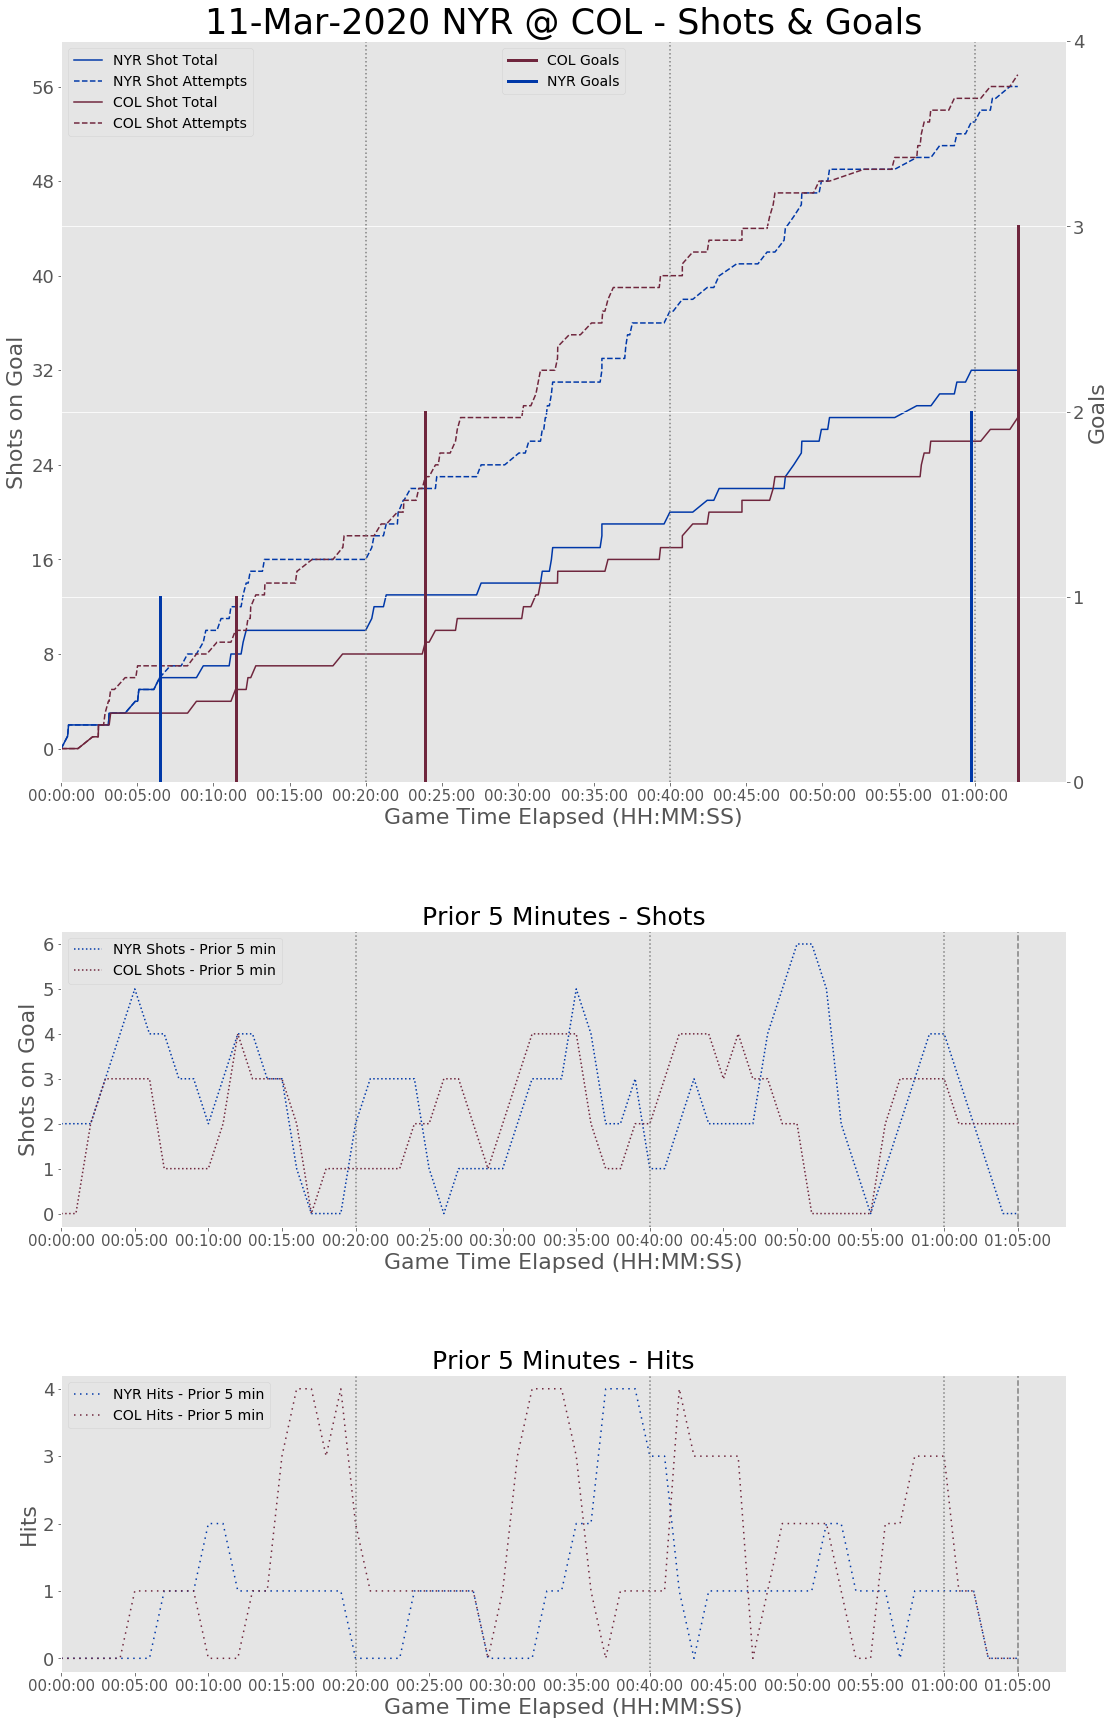

In [22]:
style.use('ggplot')
#Create figure and axis objects for plot
fig = plt.figure(figsize=(18,30))
widths = [15,15]
heights = [9,5]
gs = gridspec.GridSpec(4,1)

###################################################################### Create Top Plot - Shots, Goals, Prior 5 Stats
ax0 = fig.add_subplot(gs[:2,0])

#Plot shots and differential data
plt.plot(plays.index,plays[Away + " Shot Total"],c=Away_Color,label=Away + " Shot Total")
plt.plot(plays.index,plays[Away + " Shot Attempts"],c = Away_Color, linestyle='--', label=Away + " Shot Attempts")
#plt.plot(prior_5_shots.index,prior_5_shots[Away + " Shots - Prior 5 min"],c=Away_Color,linestyle='dotted',label=Away + " Shots - Prior 5 min")

plt.plot(plays.index,plays[Home + " Shot Total"],c=Home_Color,label=Home + " Shot Total")
plt.plot(plays.index,plays[Home + " Shot Attempts"],c = Home_Color, linestyle='--', label=Home + " Shot Attempts")
#plt.plot(prior_5_shots.index,prior_5_shots[Home + " Shots - Prior 5 min"],c=Home_Color,linestyle='dotted',label=Home + " Shots - Prior 5 min")

plt.xlabel('Game Time Elapsed (HH:MM:SS)')
plt.ylabel('Shots on Goal')
plt.legend(loc=2)

#Add vertical bars to graph to mark end of periods.
plt.axvline(x=1200,c='grey',linestyle='dotted')
plt.axvline(x=2400,c='grey',linestyle='dotted')
plt.axvline(x=3600,c='grey',linestyle='dotted')

r = 65
if plt.xlim(0)[1] >= 4000:
    plt.axvline(x=3900,c='grey',linestyle='--')
    r = 70

ax0.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(b=None)
mpl.rc('legend', fontsize=12)    # legend fontsize

###################################################################### Add goals to right side axis
ax1 = ax0.twinx()

#Plot goals per team
#Define labels to use for legend
my_label = {'Home' : Home + " Goals", 'Away' : Away + " Goals"}

#Add red vertical lines for home goals
for i in range(0,home_goals.shape[0]):
    goals = home_goals[Home + " Goals"].iloc[i]
    g_time = (60 * home_goals.Hour.iloc[i].max()) \
              + home_goals.Minute.iloc[i].max() \
              + (home_goals.Seconds.iloc[i].max()/60)
    plt.axvline(x = 60*g_time,ymin=0,ymax=goals / (max_Goal+1),c=Home_Color,label=my_label['Home'], lw = 3)
    my_label['Home'] = "_nolegend_"
    
#Add blue vertical lines for away goals
for i in range(0,away_goals.shape[0]):
    goals = away_goals[Away + " Goals"].iloc[i]
    g_time = (60 * away_goals.Hour.iloc[i].max()) \
             + away_goals.Minute.iloc[i].max() \
             + (away_goals.Seconds.iloc[i].max()/60)
    plt.axvline(x = 60*g_time, ymin=0, ymax = goals / (max_Goal+1),c=Away_Color,label=my_label['Away'], lw = 3)
    my_label['Away'] = "_nolegend_"
    
#Define formatting function for x axis
formatter = mpl.ticker.FuncFormatter(lambda ms, x: time.strftime('%H:%M:%S', time.gmtime(ms)))
ax1.xaxis.set_major_formatter(formatter)

x = [i * 60 for i in range(0,r,5)]
ax1.set_xticks(x)

#Format goals axis so that only round integers are displayed
max_goals = plays[[Away + " Goals",Home + " Goals"]].iloc[-1].max()
y = [i for i in range(0,max_goals+2)]
ax1.set_yticks(y)

#Fill between bars marking penalty kill/power play - Test
######################################################################
#ax1.axvspan(7*60,9*60,alpha=0.25,color='#236192')
#ax1.axvspan(8*60,10*60,alpha=0.25,color='#ce1126')
######################################################################

mpl.rc('font', size=15)          # controls default text sizes
mpl.rc('axes', titlesize=35)     # fontsize of the axes title
ax0.yaxis.label.set_fontsize(22)
ax1.yaxis.label.set_fontsize(22) 
ax0.xaxis.label.set_fontsize(22) # fontsize of the x and y labels
mpl.rc('xtick', labelsize=15)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=18)    # fontsize of the tick labels
mpl.rc('legend', fontsize=14)    # legend fontsize
mpl.rc('figure', titlesize=24)   # fontsize of the figure title

plt.ylabel('Goals')
plt.title(f"{gameday} {Away} @ {Home} - Shots & Goals")
plt.legend(loc=9)

################################################################### Create 2nd Plot - Prior 5 min shots
ax2 = fig.add_subplot(gs[2,0])
mpl.rc('axes', titlesize=25)     # fontsize of the axes title
plt.title('Prior 5 Minutes - Shots')

#Plot prior 5 minutes shot data
plt.plot(prior_5_shots.index,prior_5_shots[Away + " Shots - Prior 5 min"],c=Away_Color,linestyle='dotted',label=Away + " Shots - Prior 5 min")
plt.plot(prior_5_shots.index,prior_5_shots[Home + " Shots - Prior 5 min"],c=Home_Color,linestyle='dotted',label=Home + " Shots - Prior 5 min")

plt.xlabel('Game Time Elapsed (HH:MM:SS)')
plt.ylabel('Shots on Goal')
plt.legend(loc=0)

#Add vertical bars to graph to mark end of periods.
plt.axvline(x=1200,c='grey',linestyle='dotted')
plt.axvline(x=2400,c='grey',linestyle='dotted')
plt.axvline(x=3600,c='grey',linestyle='dotted')

r = 65
if plt.xlim(0)[1] >= 4000:
    plt.axvline(x=3900,c='grey',linestyle='--')
    r = 70

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_formatter(formatter)

x = [i * 60 for i in range(0,r,5)]
ax2.set_xticks(x)
plt.grid(b=None)
ax2.yaxis.label.set_fontsize(22) 
ax2.xaxis.label.set_fontsize(22) # fontsize of the x and y labels
mpl.rc('xtick', labelsize=15)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=18)    # fontsize of the tick labels
mpl.rc('legend', fontsize=14)    # legend fontsize

###################################################################### Add hits - prior 5 mins to new axis object
ax3 = fig.add_subplot(gs[3,0])
plt.title('Prior 5 Minutes - Hits')

ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.xaxis.set_major_formatter(formatter)
plt.grid(b=None)

x = [i * 60 for i in range(0,r,5)]
ax3.set_xticks(x)

plt.plot(prior_5_hits.index,prior_5_hits[Away + " Hits - Prior 5 min"],c=Away_Color,linestyle=(0, (1, 3)),label=Away + " Hits - Prior 5 min")
plt.plot(prior_5_hits.index,prior_5_hits[Home + " Hits - Prior 5 min"],c=Home_Color,linestyle=(0, (1, 3)),label=Home + " Hits - Prior 5 min")

#Add vertical bars to graph to mark end of periods.
plt.axvline(x=1200,c='grey',linestyle='dotted')
plt.axvline(x=2400,c='grey',linestyle='dotted')
plt.axvline(x=3600,c='grey',linestyle='dotted')

r = 65
if plt.xlim(0)[1] >= 4000:
    plt.axvline(x=3900,c='grey',linestyle='--')
    r = 70

plt.xlabel('Game Time Elapsed (HH:MM:SS)')
plt.ylabel('Hits')
    
ax3.yaxis.label.set_fontsize(22) 
ax3.xaxis.label.set_fontsize(22) # fontsize of the x and y labels
mpl.rc('xtick', labelsize=15)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=18)    # fontsize of the tick labels
mpl.rc('legend', fontsize=14)    # legend fontsize
plt.legend(loc=0)


gs.update(wspace=0.5, hspace=0.50)
plt.savefig(f"{gameday} {Away} @ {Home} - Shots & Goals.png")
plt.show()